<!-- <a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/zerlina-compute-physical/compute_physical.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

<a href="https://github.com/WinetraubLab/coregister-xy/blob/zerlina-compute-physical/compute_physical.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a> -->

# Overview
Use this notebook to get alignment information from ImageJ image registration.

In [10]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown How to use this notebook: [See Instructions](https://docs.google.com/document/d/1G2AME1q6XQhxQ1A2FhkfpktaSFpNXSNQB6mEWwM0YM0/edit?usp=sharing)
import numpy as np

# @markdown Input Paths:
# @markdown Leave either path blank to load a file from local file system.
trakem_xml_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-09-04 Multiple Barcode Alignment/align3.xml" # @param {type:"string"}
fluorescent_patch_number = 8 # @param {type:"integer"}
# @markdown For the alignment of multiple templates to one fluorescent image, specify the patch numbers of each template in the TrakEM stack.
template_patch_1 = 11 # @param {type:"integer"}
template_patch_2 = 14 # @param {type:"integer"}
template_patch_3 = 17 # @param {type:"integer"}

# @markdown Z-depth of each template, in um:
template_1_z = 68 # @param {type:"number"}
template_2_z = 52 # @param {type:"number"}
template_3_z = 56 # @param {type:"number"}

zs = np.array([template_1_z, template_2_z, template_3_z])

template_size = 401
um_per_pixel = 2

# @markdown Optional: Paths to XML files with exported landmarks. One file per barcode pair. Export each set of selected landmarks.
landmarks_file_1 = "" # @param {type:"string"}
# landmarks_file_2 = "" # @param {type:"string"}
# landmarks_file_3 = "" # @param {type:"string"}

# landmarks_files = [landmarks_file_1, landmarks_file_2, landmarks_file_3]
landmarks_files = [landmarks_file_1]

from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

if not trakem_xml_path:
  print("Upload saved TrakEM project:")
  uploaded = files.upload()
  trakem_xml_path = list(uploaded.keys())[0]
  trakem_xml_path = os.path.join(os.getcwd(), trakem_xml_path)

for idx, f in enumerate(landmarks_files):
  if not f:
    print("Upload saved landmark file", idx+1, ", cancel upload if none:")
    uploaded = files.upload()
    if uploaded:
      landmarks_f = list(uploaded.keys())[0]
      landmarks_f = os.path.join(os.getcwd(), f)
      landmarks_files.append(landmarks_f)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Upload saved landmark file 1 , cancel upload if none:


In [11]:
# @title Environment Setup
!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

# from plane.fit_plane import FitPlane
from plane.fit_template import FitTemplate
import matplotlib.pyplot as plt
import os
from google.colab import files
import math

%cd ..

fatal: destination path 'coregister-xy' already exists and is not an empty directory.
/content/coregister-xy
/content


In [12]:
# @title Compute Physical Transform Parameters, relative to image origin
ps = []
templates = [template_patch_1, template_patch_2, template_patch_3]
thetas = []
dist_per_pixel_arr = []
centers = []
avgscale = 0
for i in range(0,3):
  if templates[i] == -1:
    continue
  print("Template ", i+1, " (patch number ", templates[i], "):")
  if len(landmarks_files) > i:
    project = FitTemplate.from_imagej_xml(trakem_xml_path, fluorescent_patch_number, templates[i], landmarks_files[i], True)
    if landmarks_files[i]:
      error_px = project.find_transformation_error()
      avg_um_px = np.mean([project.calc_real_scale(um_per_pixel, 0), project.calc_real_scale(um_per_pixel, 90)])
      print("Alignment Error: ", "{:.2f}".format(error_px), "px /", "{:.2f}".format(avg_um_px * error_px), "um\n")
    else:
      print()
  else:
    project = FitTemplate.from_imagej_xml(trakem_xml_path, fluorescent_patch_number, templates[i], None, True)
  ps.append(project)
  s = project.scale
  theta_deg = project.theta_deg
  shear_mag = project.shear_magnitude
  shear_vec = project.shear_vector
  tx = project.tx
  ty = project.ty
  print("Center (x,y): ", "{:.2f}".format(tx + template_size/2),", ", "{:.2f}".format(ty + template_size/2), "px")
  centers.append([tx + template_size/2, ty + template_size/2])
  print("Rotation (deg): ", "{:.2f}".format(theta_deg))
  thetas.append(theta_deg)
  print("Scaling: ", "{:.2f}".format(s))
  print("Shear magnitude: ", "{:.2f}".format(shear_mag), "  Shear direction: [", "{:.2f}".format(shear_vec[0]), ",", "{:.2f}".format(shear_vec[1]), "]")
  print("\n")
  avgscale += s
  i += 1
avgscale /= 3

# convert centers to distance, then append zs on axis
centers = np.array(centers)
centers = centers * (um_per_pixel / avgscale) # convert fluorescent units from pixels to um
centers_z = np.column_stack((centers, zs))

print("Centers, in um:\n",centers_z)
print()


Template  1  (patch number  11 ):

Center (x,y):  698.93 ,  2920.88 px
Rotation (deg):  7.28
Scaling:  1.96
Shear magnitude:  -0.05   Shear direction: [ -0.99 , -0.10 ]


Template  2  (patch number  14 ):
Center (x,y):  1658.59 ,  3113.83 px
Rotation (deg):  7.32
Scaling:  1.87
Shear magnitude:  0.03   Shear direction: [ 0.72 , 0.70 ]


Template  3  (patch number  17 ):
Center (x,y):  738.31 ,  1995.97 px
Rotation (deg):  6.21
Scaling:  1.92
Shear magnitude:  0.03   Shear direction: [ 0.79 , -0.62 ]


Centers, in um:
 [[ 729.56326015 3048.88426882   68.        ]
 [1731.28264177 3250.290297     52.        ]
 [ 770.67114278 2083.43973755   56.        ]]



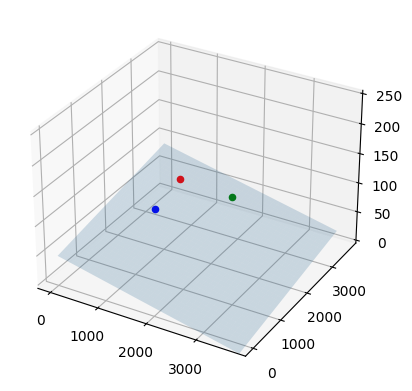

Rotate 0.67 degrees around x-axis, then rotate 1.05 degrees around y-axis



In [13]:
def get_plot_plane_equation_from_points(points, plot=True):

    # Get plane EQ and PLOT it

    p1, p2, p3 = points
    v1 = p3 - p1
    v2 = p2 - p1
    normal = np.cross(v1, v2)
    if normal[2] < 0:  # If the Z component of the normal is negative\n",
        normal = -normal  # Flip the normal vector\n",
    a,b,c = normal
    d = -np.dot(normal, p3)

    # Create the figure
    fig = plt.figure()
    xx, yy = np.meshgrid(np.arange(0,np.max(points)+500, 100), np.arange(0,np.max(points)+500, 100))
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    if plot:
        # Add an axes
        ax = fig.add_subplot(111,projection='3d')

        # plot the surface
        ax.plot_surface(xx, yy, z, alpha=0.2)
        ax.set_zlim(0, 250)

        # and plot the point
        ax.scatter(p2[0] , p2[1] , p2[2],  color='green')
        ax.scatter(p1[0] , p1[1] , p1[2],  color='red')
        ax.scatter(p3[0] , p3[1] , p3[2],  color='blue')
        plt.show()

    return normal[0], normal[1], normal[2], d

def get_plane_info(points):
    A, B, C, D = get_plot_plane_equation_from_points(points)

    for point in points:
        x, y, z = point
        result = A * x + B * y + C * z + D
        assert round(result) == 0

    norm_n = np.sqrt(A**2 + B**2 + C**2)

    # Angles with the axes (in radians)
    alpha = np.arccos(abs(A) / norm_n)
    beta = np.arccos(abs(B) / norm_n)
    gamma = np.arccos(abs(C) / norm_n)

    # Convert to degrees
    alpha_deg = np.degrees(alpha)
    beta_deg = np.degrees(beta)
    gamma_deg = np.degrees(gamma)

    # Complementary angles (plane angles with axes)
    theta_x = 90 - alpha_deg
    theta_y = 90 - beta_deg
    theta_z = 90 - gamma_deg

    norm = np.linalg.norm(np.array([A,B,C]))
    plane_norm = np.array([A/norm, B/norm, C/norm])

    # find theta_x and theta_y to rotate [0,0,1] to match plane_norm
    theta_y = np.arctan2(A, C)
    theta_x = -np.arctan2(B, np.sqrt(A**2 + C**2))
    theta_y_deg = np.degrees(theta_y)
    theta_x_deg = np.degrees(theta_x)

    print(f"Rotate {theta_x_deg:.2f} degrees around x-axis, then rotate {theta_y_deg:.2f} degrees around y-axis")
    print()

get_plane_info(centers_z)